In [4]:
from collections import defaultdict, Counter
from operator import itemgetter
import re,operator
import bz2, json
from collections import defaultdict
import cmath
WORD_LEN_COEFF = 1
THRESHOLD_COEFF = 0.5
DROP = 2.1
DROP_1 = 2
AFFIX_LEN = 1

trie, voc, words = None, None, None


def main():
    global trie, words, voc
    
    voc = load_voc()
    words = list(voc.keys())
    word_count = sum([voc[k] for k in voc])
    average_word_len = sum([len(w)*voc[w] for w in words]) / word_count
    len_search = int(average_word_len * WORD_LEN_COEFF) #это максимальная разрешенная длина аффикса
    print("{} словоформ, {} словоупотреблений, средняя длина слова {} ".format(len(words), word_count, average_word_len))

    # подсчет безусловных вероятностей букв
    # trie, prob = build_trie_and_prob(voc)
    prob = json.load(open("prob.json", encoding="utf-8"))
    strie = bz2.BZ2File('trie.json.bz2', 'r').read().decode(encoding='utf-8')
    trie = json.loads(strie)
    del strie
    print("Безусловные вероятности первых 10 букв:\n========================\n", 
        sorted([(letter,nv) for letter,nv in prob.items()], key=itemgetter(1), reverse=True)[:10])

    # подсчет условных вероятностей букв
    cond_prob = build_cond_prob(voc, prob, len_search)

    # информанты - это буквы с макс значением КФ в каждой позиции
    informants = find_informants(prob, cond_prob, len_search)
    print("ИНФОРМАНТЫ:\n===================")
    print(informants)

    # отправной аффикс начинаем строить с информанта имеющего max КФ
    affix=informants[0]
    affix=extend_right(*affix)
    affix=extend_left(affix, trie, len_search)
    print("ОТПРАВНОЙ АФФИКС:\n===================")    
    print(affix)



def load_voc():
    # Загрузить словарь количеств из файла.
    # Словарь содержит частоты слов в виде {слово: число вхождений в корпус, ... },
    # например {"көппөҕү" : 4, "хазар" : 3, ...}
    #
    # корпус в формате txt  занимет 174 МБ, словарь частот в json 10,4МБ,
    # после сжатия в формат .bz2 1,7 МБ
    svoc = bz2.BZ2File('voc.json.bz2', 'r').read().decode(encoding='utf-8')
    voc = json.loads(svoc)
    del svoc
    return voc


def build_trie_and_prob(voc):
    #подсчитываем частоты букв и строим дерево оконочаний
    prob = defaultdict(lambda: 0)
    trie = {'n':0}
    for w,n in voc.items(): #для каждого слова в списке
        word = w[::-1]  # переворачиваем слово, читаем слово с конца
        current_dict = trie
        trie['n'] += n
        for letter in word:  # для буквы в слове
            prob[letter]+=n
            current_dict = current_dict.setdefault(letter, {'n': 0}) #получить значение из словаря по ключу.
                                                                     #Автоматически добавляет элемент словаря, если он отсутствует.
            current_dict['n']+=n
        current_dict['#'] = n

    total = sum([n for n in prob.values()])#84263863
    for k,v in prob.items():
        prob[k] = v/total

    return trie, prob


def build_cond_prob(voc, prob, len_search):
    letters = list(prob.keys())

    cond_prob = defaultdict(lambda: 0) #словарь для условных вероятностей
    total = defaultdict(lambda: 0)

    for word,n in voc.items():#для слова в словаре
        positions = range(-min(len_search, len(word) - 2), 0) # from -7 to 0
        for i in positions:
            cond_prob[(i, word[i])] += n
            total[i] += n # dictionary with prob of char words?

    for posChar in cond_prob: #получаем из частот вероятности
        i = posChar[0]
        cond_prob[posChar] /= total[i]

    return cond_prob


def find_informants(prob, cond_prob, len_search):
    max_cond = defaultdict(lambda: 0.0)
    maxlet = ['']*8
    #для каждой позиции ищем букву с наибольшим значением условной вероятности,
    for posChar in cond_prob:#цикл по позициям букв в условной вероятности
        aff_len = posChar[0]
        if cond_prob[posChar] > max_cond[aff_len]:
            max_cond[aff_len] = cond_prob[posChar]
            maxlet[-aff_len] = posChar[1]

    print("Наиболее частые буквы по позициям:\n============================\n", maxlet[-1:0:-1],"\n")

    print("Максимальные вероятности по позициям:\n============================\n", max_cond,"\n")
    #порог медиального разбиения - половина условной вероятности , буквы с УВ не меньше порога - верхнее подмножеств
    cond_prob_sup = {}
    for posChar in cond_prob:
            i = posChar[0]
            if cond_prob[posChar] > THRESHOLD_COEFF * max_cond[i]:
                cond_prob_sup[posChar] = cond_prob[posChar]

    # КФ = условная вер по данной позиции / безусл вероятность
    cf = {}
    for posChar in cond_prob_sup:
        char = posChar[1]
        cf[posChar] = cond_prob_sup[posChar] / prob[char]

    print("КФ для верхних подмножества:\n====================\n");
    for aff_len in set(map(itemgetter(0), cf.keys())):
        print(aff_len, "**")
        for k,v in cf.items():
            if k[0] == aff_len:
                print(k[1], "{:.4f}".format(v), end="  ")
        print("")

    # информанты - это буквы с макс значением КФ в каждой позиции
    informants = []
    for aff_len in range(-len_search, 0):
        kmax = max({k for k in cf if k[0] == aff_len}, key=lambda k: cf[k])
        informants.append((kmax[1], aff_len, cf[kmax]))

    informants.sort(key = itemgetter(2), reverse=True)
    return informants


def extend_right(char, pos, cf):
    if pos == -1:#если информант в последней позиции, то расширять некуда
        return char #возвращаем информант как аффикс
    d = defaultdict(int)
    for w,n in voc.items():#для буквы и частоты в словаре
        if w[pos:pos+1]==char: #если буква в позиции равна нашей, то посчитаем это окончание
            d[w[pos+1:]]+=n
    return char+max(d.keys(), key=lambda end: d[end]) #прибавляем к информанту самое частое окончание


def extend_left(affix, trie, len_search):
    #расширяем аффикс влево используя trie

    current_dict = trie
    for ch in affix[::-1]:
        current_dict = current_dict[ch]

    aff_len = len(affix)

    """ 
    Для поиска буквы слева:
        идем по дереву trie
        по две самые частотные буквы делим друг на друга, при мере перепада большей 1.5 прибавляем к информанту более частую из них.
       Иначе начинаем рассматривать по две самые частотные буквы/на следующие две, 
    если мера перепада в одной из них больше двух, то из данной пары берем более частотную и прибавляем ее к аффиксу. 
    """
    #пока позиция символа в слове больше разрешенной длины аффикса
    while aff_len < len_search:
        #составляем список всех букв предшествующих аффиксу с количествами
        L = [(l, current_dict[l]["n"]) for l in current_dict.keys() if l not in '#n']
        #сортируем по количествам
        L.sort(key = itemgetter(1), reverse = True)
        #if affix=='нан':
            #import pdb
            #pdb.set_trace()
        ch = L[0][0]
        if L[0][1] > DROP*L[1][1]:
            affix = ch + affix
            current_dict = current_dict[ch]
        else:
            if (L[0][1]+L[1][1]) / (L[2][1]+L[3][1]) > 2:
                affix = ch + affix
                current_dict = current_dict[ch]
            else:
                break
        aff_len+=1

    return affix


def more():


    #базы первого вида
    bases = [w[0:-aff_len] for w,n in voc.items() if w[-aff_len:]==affix and n>3] #отбрасываем информантный аффикс и получаем базы 1го вида
    #bases.sort(key = itemgetter(1), reverse = True)
    bases = sorted(bases)
    #спектр остатков первого вида, т.е. находим остальные слова содержащие базы 1го вида, и отсекаем их и получаем СОПП
    ostat = defaultdict(int)
    for b in bases:
        for w,n in voc.items():
            if not w.startswith(b):
                continue
            ostat[w[len(b)+1:]]+=n

    #print(ostat)

    # теперь нужно упорядочить спектр остатков по частоте в убывающем порядке
    ostat=ostat.sort(key = itemgetter(0), reverse=True)
    #выделяем из спектра сотатков верхнее подмножество, для р.яз первые 6 аффиксов спектра
    # - для каждой позиции находится буква с наибольшим УВ, половина ее УВ - порог медиального разбиения
    #буквы, УВ которых не меньше данного порога входят в верхнее подмножество

    #определим независимую вероятность буквосочетания(остатков верхнего подмножества), как произведение независимых вероятностей букв входящих в него.
    # uncond_prob = defaultdict()
    # for k,v in ostat.items():
    #     for
    #         uncond_prob[k] *= prob[k]

    #затем находим условную вероятность остатка(?), по максимальному значению условной вероятности определяем
    #второй информантный аффикс по максимуму условной вероятности (в верхнем подмножестве)
    #сопоставляем количество основ сочетающихся с первым информантным аффиксом и
    #число основ со вторым информантным аффиксом стр38

    #Языковой шлейф. Шлейфовый порог при работе с базами n-го вида - выберем число n
    # т.е. убираем из списка баз все основы с суммарной синтагматической встречаемостью(вероятность относительно текста)
    #с любыми остатками, меньшую или равную n
    #полученный список будет содержать М баз n-го вида

    #после применения шлейфового порога и вычисления коэффициента редукции вычислим меру редукции

    # Compute reduction coefficient
    k = 10**(cmath.log(average_word_len, 10)\
                    / (1+0.02 * cmath.log( len(voc), 10)) )
        # Compute reduction threshold
    thres_reduction = 1 / average_word_len


In [5]:
main()

386233 словоформ, 11859267 словоупотреблений, средняя длина слова 7.1053179762290535 
Безусловные вероятности первых 10 букв:
 [('а', 0.13174638100795355), ('т', 0.07463523242460413), ('н', 0.07183703410321932), ('р', 0.06989005476760542), ('э', 0.06769593508904286), ('и', 0.06497202721408583), ('ы', 0.05657750345483212), ('л', 0.052736912856701096), ('у', 0.048080219156342266), ('о', 0.04801633649290444)]
Наиболее частые буквы по позициям:
 ['а', 'а', 'т', 'а', 'т', 'а', 'н'] 

Максимальные вероятности по позициям:
 defaultdict(<function find_informants.<locals>.<lambda> at 0x0000000004FF8378>, {-6: 0.13725284548556266, -5: 0.10984460793132571, -4: 0.13300193926114215, -3: 0.11746170593037474, -2: 0.21185955687204952, -1: 0.22671356984582827, -7: 0.10984867258690777}) 

КФ для верхних подмножества:

-1 **
н 3.1559  р 2.0092  а 1.1595  
-7 **
ы 0.9773  р 1.1054  а 0.8338  л 1.7512  т 1.0604  и 0.9824  
-6 **
р 0.9975  а 1.0418  т 0.9701  э 1.0297  л 1.6040  
-5 **
а 0.7812  н 0.8144  т

In [6]:
trie

KeyboardInterrupt: 

In [7]:
len(trie)

39

In [10]:
def n(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return current_node['n']
def n2(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    return sorted([(k,subtree['n']) for k, subtree in current_node.items() if k not in '#n'], key=itemgetter(1), reverse=True)


In [11]:
n2('ртан')

[('а', 9999),
 ('ы', 388),
 ('о', 378),
 ('у', 250),
 ('е', 111),
 ('т', 60),
 ('и', 23),
 ('д', 14),
 ('я', 2),
 ('в', 2),
 ('п', 1),
 ('ё', 1),
 ('ю', 1),
 ('г', 1),
 ('н', 1)]

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
def diag(a):
    current_node = trie
    for char in a[::-1]:
        current_node = current_node[char]
    pairs = sorted([(k,subtree['n']) for k, subtree in current_node.items() if k not in '#n'], 
                   key=itemgetter(1), 
                   reverse=True)
    kol = [p[1] for p in pairs]
    chs = [p[0] for p in pairs]
    plt.figure(figsize=(14,7))
    plt.bar(np.arange(len(kol)), kol, tick_label=chs)
    plt.show()

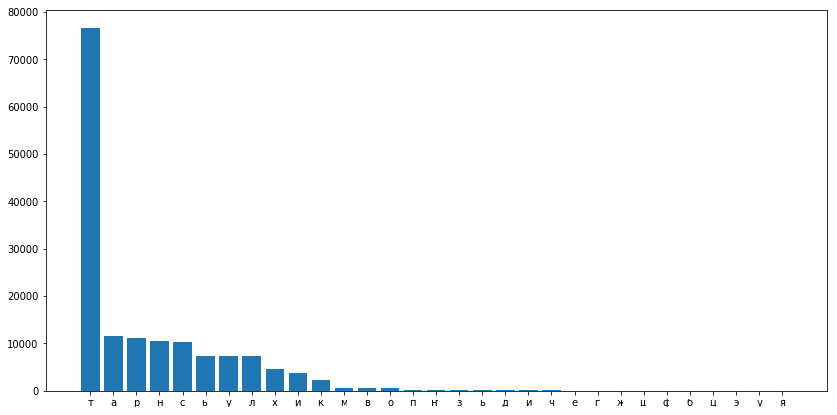

In [20]:
diag('тан')

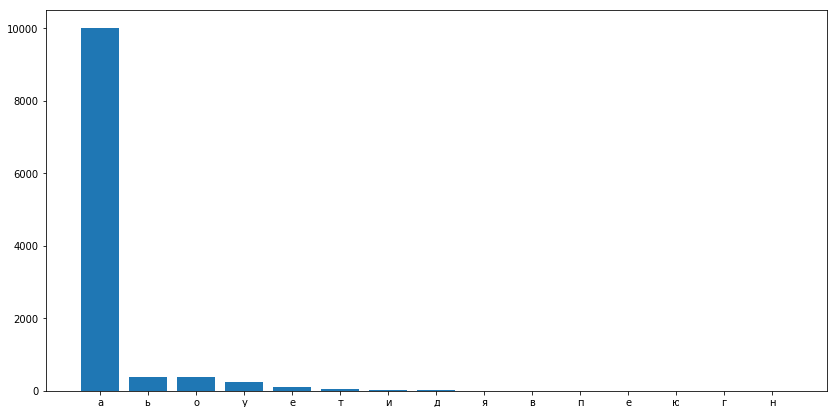

In [21]:
diag('ртан')

In [18]:
n2('ртан')

[('а', 9999),
 ('ы', 388),
 ('о', 378),
 ('у', 250),
 ('е', 111),
 ('т', 60),
 ('и', 23),
 ('д', 14),
 ('я', 2),
 ('в', 2),
 ('п', 1),
 ('ё', 1),
 ('ю', 1),
 ('г', 1),
 ('н', 1)]

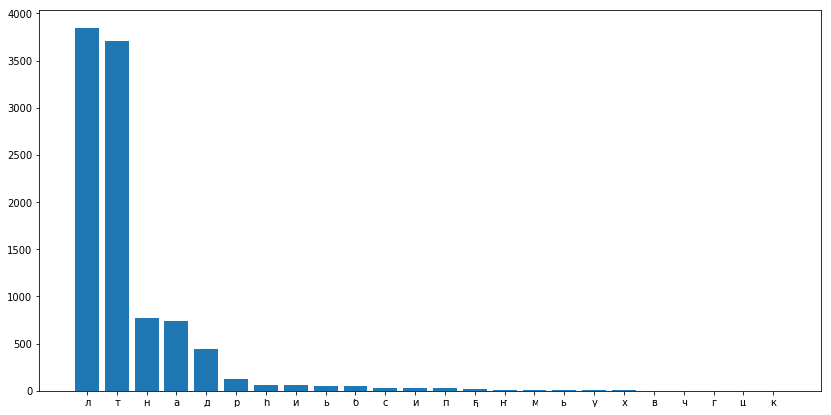

In [22]:
diag('артан')

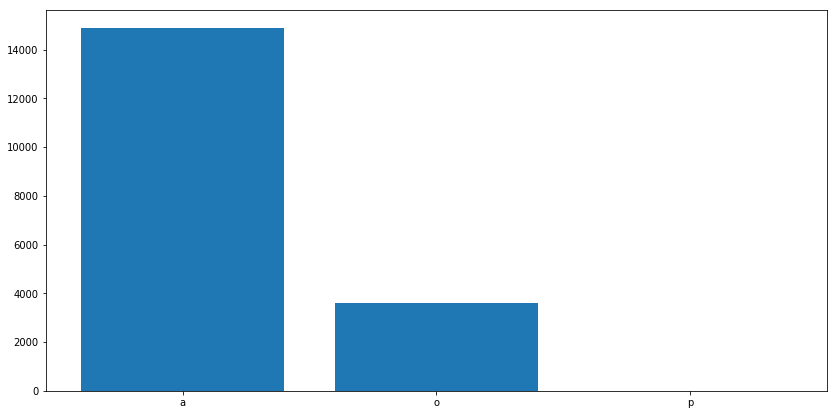

In [23]:
diag('хтара')

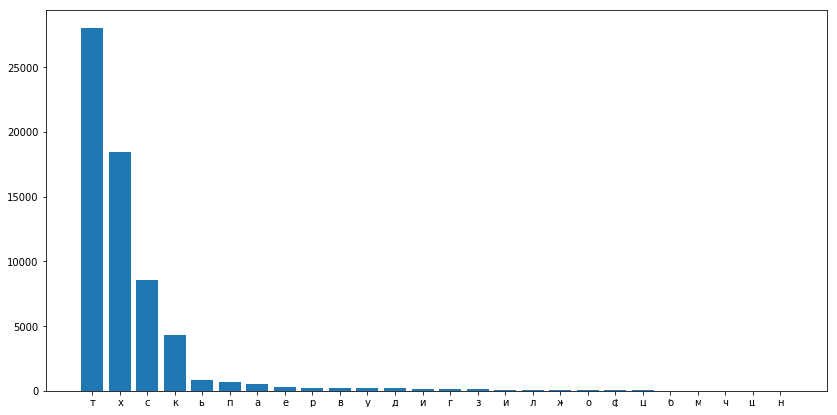

In [24]:
diag('тара')